In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as rnd
from scipy.stats import norm
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
from skimage import io
from PIL import Image
from io import BytesIO
import requests
from skimage.util import view_as_windows
from stepmix.stepmix import StepMix

In [2]:
# Importation des données
star_data = pd.read_csv ('data_star.csv')

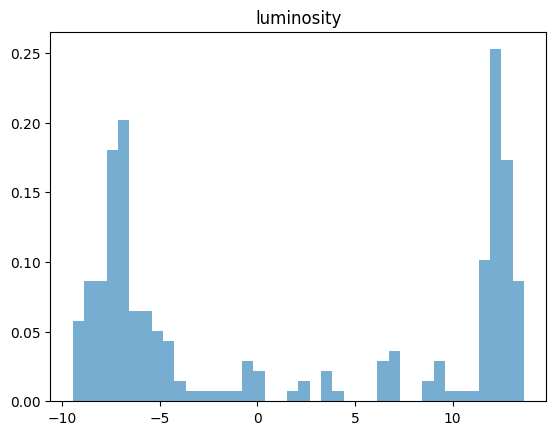

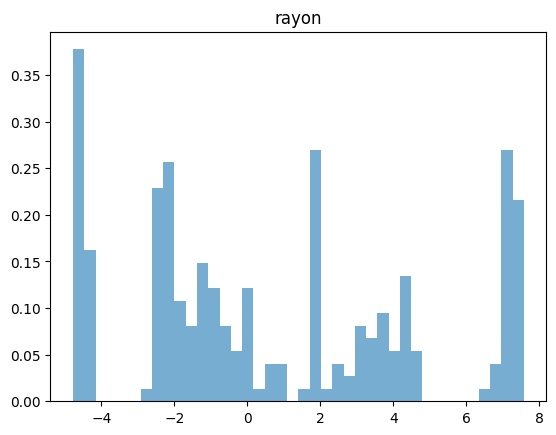

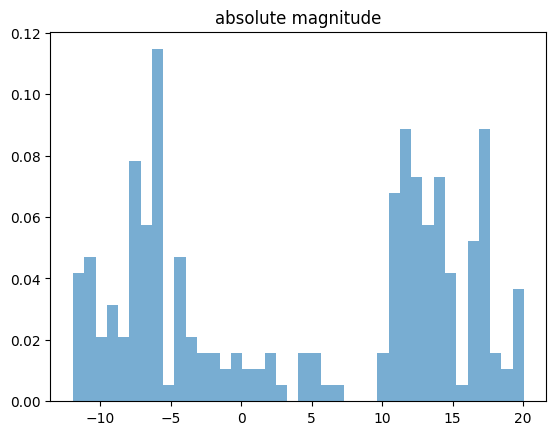

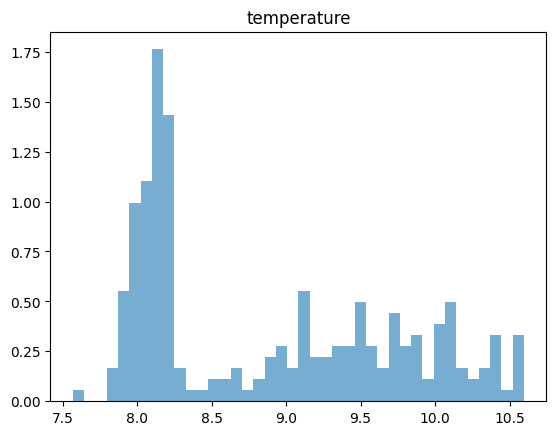

In [3]:
# Modification des données pour avoir des variables catégorielles

plt.hist(np.log(star_data["Luminosity (L/Lo)"]), density = True, alpha = 0.6, bins = 40)
plt.title('luminosity')
plt.show()
plt.hist(np.log(star_data["Radius (R/Ro)"]), density = True, alpha = 0.6, bins = 40)
plt.title('rayon')
plt.show()
plt.hist(star_data["Absolute magnitude (Mv)"], density = True, alpha = 0.6, bins = 40)
plt.title('absolute magnitude')
plt.show()
plt.hist(np.log(star_data["Temperature (K)"]), density = True, alpha = 0.6, bins = 40)
plt.title('temperature')
plt.show()

In [4]:
# categorisation pour le rayon

condition_rayon = [
    np.log(star_data["Radius (R/Ro)"]) < 0,
    ((np.log(star_data["Radius (R/Ro)"]) >= 0) & (np.log(star_data["Radius (R/Ro)"]) <= 4)),
    np.log(star_data["Radius (R/Ro)"]) > 4
]

categories_rayon = [-1, 0, 1]

star_data["Radius categ"] = np.select(condition_rayon, categories_rayon)
print(star_data[['Radius categ']].value_counts())

Radius categ
-1              127
 1               58
 0               55
Name: count, dtype: int64


In [5]:
# categorisation pour la luminosité 

condition_lum = [
    np.log(star_data["Luminosity (L/Lo)"]) < -4,
    ((np.log(star_data["Luminosity (L/Lo)"]) >= -4) & (np.log(star_data["Luminosity (L/Lo)"]) <= 8)),
    np.log(star_data["Luminosity (L/Lo)"]) > 8
]

categories_lum = [-2, 0, 3]

star_data["Luminosity categ"] = np.select(condition_lum, categories_lum)
print(star_data[['Luminosity categ']].value_counts())

Luminosity categ
-2                  116
 3                   94
 0                   30
Name: count, dtype: int64


In [6]:
# categorisation pour absolute magnitude

condition_mag = [
    star_data["Absolute magnitude (Mv)"] < -5,
    (star_data["Absolute magnitude (Mv)"] >= -5) & (star_data["Absolute magnitude (Mv)"] <= 10),
    (star_data["Absolute magnitude (Mv)"] >= 10) & (star_data["Absolute magnitude (Mv)"] <= 15),
    star_data["Absolute magnitude (Mv)"] > 15
]

categories_mag = [-2, 0, 3, 5]

star_data["Abs mag categ"] = np.select(condition_mag, categories_mag)
print(star_data[['Abs mag categ']].value_counts())

Abs mag categ
-2               80
 3               80
 0               40
 5               40
Name: count, dtype: int64


In [7]:
# categorisation pour la temperature

condition_temp = [
    np.log(star_data["Temperature (K)"]) < 8.5,
    np.log(star_data["Temperature (K)"]) > 8.5
]

categories_temp = [0, 1]

star_data["Temp categ"] = np.select(condition_temp, categories_temp)
print(star_data[['Temp categ']].value_counts())

Temp categ
1             125
0             115
Name: count, dtype: int64


In [8]:
# categorisation de la couleur 
print(star_data[["Star color"]].value_counts())

Star color  
Red             112
Blue             56
Blue White       41
Yellow White     13
White            12
Yellowish         3
Orange            2
Orange Red        1
Name: count, dtype: int64


In [9]:
condition_couleur = [
    star_data["Star color"] == "Red",
    star_data["Star color"] == "Blue",
    star_data["Star color"] == "Blue White",
    star_data["Star color"] == "Yellow White",
    star_data["Star color"] == "White",
    star_data["Star color"] == "Yellowhish",
    star_data["Star color"] == "Orange",
    star_data["Star color"] == "Orange Red",
]

categories_couleur = [10, 4, 3, 1, 0, 2, 8, 9]

star_data["Couleur categ"] = np.select(condition_couleur, categories_couleur)
print(star_data[['Couleur categ']].value_counts())

Couleur categ
10               112
4                 56
3                 41
0                 15
1                 13
8                  2
9                  1
Name: count, dtype: int64


In [10]:
star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace = True)

/var/folders/vv/yd9tg_vd01b85m5mbpmc1v3r0000gn/T/ipykernel_44041/2265824004.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  star_data.replace({'Spectral Class':{'M':0, 'A':1, 'B':2, 'F':1, 'O':2, 'K':0, 'G':1 }}, inplace = True)


In [11]:
star_data_model = star_data.drop(columns = ['Star category'])
star_data_model = star_data_model.drop(columns = ['Luminosity (L/Lo)'])
star_data_model = star_data_model.drop(columns = ['Radius (R/Ro)'])
star_data_model = star_data_model.drop(columns = ['Absolute magnitude (Mv)'])
star_data_model = star_data_model.drop(columns = ['Star color'])
star_data_model = star_data_model.drop(columns = ['Temperature (K)'])

print(star_data_model)

     Star type  Spectral Class  Radius categ  Luminosity categ  Abs mag categ  \
0            0               0            -1                -2              5   
1            0               0            -1                -2              5   
2            0               0            -1                -2              5   
3            0               0            -1                -2              5   
4            0               0            -1                -2              5   
..         ...             ...           ...               ...            ...   
235          5               2             1                 3             -2   
236          5               2             1                 3             -2   
237          5               1             1                 3             -2   
238          5               1             1                 3             -2   
239          5               2             1                 3             -2   

     Temp categ  Couleur ca

In [18]:
# prediction avec melange gaussien categoriel

model_categ = StepMix(n_components = 6, measurement="categorical")
model_categ.fit(star_data_model)

Y_pred_bic = model_categ.predict(star_data_model)
print(Y_pred_bic)

Fitting StepMix...


Initializations (n_init) : 100%|██████████| 1/1 [00:00<00:00, 83.65it/s, max_LL=-809, max_avg_LL=-3.37]

[0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5
 5 5 5 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 3 3 3 3
 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4
 4 4 5 5 5 5 5 5 5 5 5 5 2 2 2 2 2 2 2 2 2 2 1 1 1 2 1 1 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [16]:
star_data['prediction class'] = Y_pred_bic

In [17]:
classe_array = np.array(star_data['Star category'])
Y_pred_array = np.array(Y_pred_bic)
df = pd.DataFrame({
    'prediction' : Y_pred_array,
    'classe' : classe_array
})
print(df)
df.to_csv("prediction_classes.csv", index=False)

     prediction       classe
0             2  Brown Dwarf
1             2  Brown Dwarf
2             2  Brown Dwarf
3             2  Brown Dwarf
4             2  Brown Dwarf
..          ...          ...
235           3   Hypergiant
236           3   Hypergiant
237           3   Hypergiant
238           3   Hypergiant
239           3   Hypergiant

[240 rows x 2 columns]
